# Quantum Neural Network for Ellipse Detection

## Introduction
This notebook demonstrates the implementation of a Quantum Neural Network (QNN) for binary image classification using Qadence, a quantum machine learning framework. The task involves distinguishing images containing ellipses from those without ellipses. This serves as a simplified example of how quantum computing can be applied to image recognition tasks.

The approach uses a hybrid quantum-classical model where:
1. Classical images are encoded into quantum states
2. Quantum circuit operations process this information
3. Measurement results are interpreted as classifications

In [1]:
import os
import itertools as it
import csv
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from tqdm import tqdm

from qadence import (
    chain, kron, QuantumCircuit, run,
    H, X, MCRY, Z, RY, RX, CNOT,
    QNN, VariationalParameter, FeatureParameter, hea
)

from qadence.draw import display

import torch
from torch import tensor
from torch.optim import Adam

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

## Generate training images
This code does all the following things:
- Creates images with and without ellipses. 
- Saves the images arrays (.npy files).
- Saves the images (.jpg files).
- Saves a label files (labels.csv) indicating whether an image contains an ellipse (1) or not (0).

In [3]:
# Constants
IMAGE_SIZE = 8  # 8x8 pixels
NUM_IMAGES = 512  # Number of images to generate
OUTPUT_DIR = "pixel_art_dataset_2"  # Output directory
LABELS_FILE = os.path.join(OUTPUT_DIR, "labels.csv")  # Labels file path
GRAYSCALE_LEVELS = 8  # Number of grayscale levels

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def create_smooth_gradient_background(size):
    """Create a smooth random gradient background."""
    corners = np.random.randint(0, GRAYSCALE_LEVELS, size=4) * (255 // (GRAYSCALE_LEVELS - 1))
    y, x = np.mgrid[0:size, 0:size] / (size - 1)
    top = corners[0] * (1 - x) + corners[1] * x
    bottom = corners[2] * (1 - x) + corners[3] * x
    gradient = top * (1 - y) + bottom * y
    return np.round(gradient).astype(np.uint8)

def add_ellipse(img_array, size):
    """Add an ellipse to the image."""
    temp_img = Image.fromarray(img_array, 'L')
    draw = ImageDraw.Draw(temp_img)
    x0, y0 = random.randint(0, size-3), random.randint(0, size-3)
    x1, y1 = x0 + random.randint(2, size//2), y0 + random.randint(2, size//2)
    fill_value = random.randint(0, GRAYSCALE_LEVELS-1) * (255 // (GRAYSCALE_LEVELS - 1))
    draw.ellipse([x0, y0, x1, y1], fill=fill_value)
    return np.array(temp_img)

def create_image(has_ellipse):
    img_array = create_smooth_gradient_background(IMAGE_SIZE)
    if has_ellipse:
        img_array = add_ellipse(img_array, IMAGE_SIZE)
    return img_array

dataset = []

for i in tqdm(range(NUM_IMAGES)):
    has_ellipse = random.random() < 0.5  # 50% chance
    img_array = create_image(has_ellipse)

    dataset.append({
        'image': img_array,
        'label': has_ellipse,
    })

df_train = pd.DataFrame(dataset)

# Show an image
img_index = 6

fig, ax = plt.subplots()
ax.imshow(df_train.image[img_index], cmap='gray')
ax.set_title(f"Has polyp: {df_train.label[img_index]}")
del fig, ax

100%|██████████| 512/512 [00:00<00:00, 14609.03it/s]


## Create QNN Circuit
 The Quantum Neural Network consists of three main parts:
 1. A feature circuit that encodes the image data into quantum states
 2. A variational (trainable) circuit that processes these states
 3. An observable that measures the output and converts it to a classification result

### Feature circuit (image input)
 First, we define feature parameters to encode each pixel of the image into quantum states.
 Each pixel value will control a rotation in the quantum circuit.

 Parameters to input the image into the circuit
 One variable per pixel, indexed by (row, col)

In [1]:
# Parameters to input the image into the circuit
# One variable per pixel, indexed by (row, col)
feature_params = {
    (row, col): FeatureParameter(f'x{row}{col}')
    for row in range(IMAGE_SIZE)
    for col in range(IMAGE_SIZE)
}

feature_params_list = list(feature_params.values())

NameError: name 'IMAGE_SIZE' is not defined

## Quantum dimension parameters
 We determine how many qubits are needed to represent row/column positions
 and create a circuit to encode pixel positions and values

In [6]:
# Quantum parameters
qdim = math.floor(math.log2(IMAGE_SIZE))  # number of qubits to encode a row or a column
n_qubits = 2*qdim + 1  # 6 para posição (3 linha + 3 coluna) + 1 para intensidade
control_qubits = list(range(n_qubits-1))

def control_state(row: int, col: int):
    row_binary = f"{row:b}".rjust(qdim, '0')
    col_binary = f"{col:b}".rjust(qdim, '0')
    state = row_binary + col_binary
    return state

ops_feature = [kron(H(i) for i in range(n_qubits - 1))]  # Hadamard para posição

for (row, col), parameter in feature_params.items():
    rotation_gate = kron(MCRY(control_qubits, n_qubits - 1, parameter * np.pi))
    
    cstate = control_state(row, col)
    qubits_to_flip = [i for i, x in enumerate(cstate) if x == '1']

    if qubits_to_flip:
        ops_feature.append(kron(X(i) for i in qubits_to_flip))
        
    ops_feature.append(rotation_gate)

    if qubits_to_flip:
        ops_feature.append(kron(X(i) for i in qubits_to_flip))

chain_feature = chain(*ops_feature)
qc_feature = QuantumCircuit(n_qubits, chain_feature)
# display(qc_feature)

### Variational circuit (trainable layers)
 Next, we define the trainable part of our quantum circuit using the hardware-efficient ansatz (HEA).
 This consists of alternating layers of rotations and entanglement, with parameters that will be 
 optimized during training.

In [7]:
depth = 5
qc_ansatz = hea(n_qubits, depth)
# display(qc_ansatz)

### Observable (circuit output)
 Finally, we define how to measure the output of our quantum circuit.
 We use a weighted sum of Z-measurements on each qubit as our observable.

In [8]:
obs_parameters = [VariationalParameter(f'z{i}') for i in range(n_qubits)]
observable = sum(obs_parameters[i] * Z(i) for i in range(n_qubits)) / n_qubits

In [9]:
ops_all = chain(*qc_feature, qc_ansatz)
qc = QuantumCircuit(n_qubits, ops_all)
model = QNN(qc, observable, inputs=feature_params_list)

## Training the circuit
 Now we train our quantum model to classify images as containing an ellipse or not.
 We'll use a classical optimizer (Adam) and a binary classification loss function.

### Prepare input data
 We normalize the pixel values to be between 0 and π, suitable for rotation angles in our quantum circuit.

In [10]:
img_train = df_train.image / 255*np.pi
y_train = torch.tensor(np.array(df_train.label), dtype=torch.float64) * 2 - 1

input_dict_train = {
    feature.name: torch.tensor([img[i, j] for img in img_train], dtype=torch.float64)
    for (i, j), feature in feature_params.items()
}

### Define loss function
 We use SoftMarginLoss which is suitable for binary classification tasks.
 The loss function encodes how well our model is performing on the training data.

In [11]:
criterion = torch.nn.SoftMarginLoss()  # SoftMarginLoss is advised for data classification

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = model.expectation(values=input_dict_train)
    
    loss = criterion(model_output.squeeze(), y_train)

    return loss

### Run optimization
 We train our model over multiple epochs, minimizing the loss function.
 As training progresses, we should see the loss decrease, indicating better classification performance.

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
n_epochs = 3000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = loss_fn(model, input_dict_train)
    loss.backward()
    optimizer.step()

    if epoch % 25 == 0:
        print(f"{epoch=}, Loss: {loss.item():.4f}")

/home/oferraz/anaconda3/envs/Pasqal/lib/python3.10/site-packages/pyqtorch/embed.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.arraylike_fn(symbol_or_numeric, device=self.device)
/home/oferraz/anaconda3/envs/Pasqal/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch=0, Loss: 0.6937
epoch=25, Loss: 0.6498
epoch=50, Loss: 0.6205
epoch=75, Loss: 0.5957
epoch=100, Loss: 0.5775
epoch=125, Loss: 0.5613
epoch=150, Loss: 0.5470
epoch=175, Loss: 0.5345
epoch=200, Loss: 0.5277
epoch=225, Loss: 0.5176
epoch=250, Loss: 0.5075
epoch=275, Loss: 0.5029
epoch=300, Loss: 0.4918
epoch=325, Loss: 0.4845
epoch=350, Loss: 0.4801
epoch=375, Loss: 0.4783
epoch=400, Loss: 0.4701
epoch=425, Loss: 0.4637
epoch=450, Loss: 0.4623
epoch=475, Loss: 0.4568
epoch=500, Loss: 0.4576
epoch=525, Loss: 0.4496
epoch=550, Loss: 0.4494
epoch=575, Loss: 0.4444
epoch=600, Loss: 0.4455
epoch=625, Loss: 0.4382
epoch=650, Loss: 0.4320
epoch=675, Loss: 0.4348
epoch=700, Loss: 0.4344
epoch=725, Loss: 0.4245
epoch=750, Loss: 0.4245
epoch=775, Loss: 0.4216
epoch=800, Loss: 0.4142
epoch=825, Loss: 0.4183
epoch=850, Loss: 0.4093
epoch=875, Loss: 0.4176
epoch=900, Loss: 0.4103
epoch=925, Loss: 0.4043
epoch=950, Loss: 0.3998
epoch=975, Loss: 0.4037
epoch=1000, Loss: 0.4000
epoch=1025, Loss: 0.

In [13]:
loss

tensor(0.3815, grad_fn=<SoftMarginLossBackward0>)

## Evaluation
 After training, we evaluate our model on a separate test set to assess its performance.

### Generate test data
 We create a new set of images for testing, following the same process used for the training data.


In [14]:
dataset_test = []

for i in tqdm(range(NUM_IMAGES)):
    has_ellipse = random.random() < 0.5  # 50% chance
    img_array = create_image(has_ellipse)

    dataset_test.append({
        'image': img_array,
        'label': has_ellipse,
    })

df_test = pd.DataFrame(dataset_test)

100%|██████████| 512/512 [00:00<00:00, 12997.17it/s]



 Prepare the test data in the same format as our training data

In [15]:
img_test = df_test.image / 255*np.pi
y_test = torch.tensor(np.array(df_test.label), dtype=torch.float64) * 2 - 1

input_dict_test = {
    feature.name: torch.tensor([img[i, j] for img in img_test], dtype=torch.float64)
    for (i, j), feature in feature_params.items()
}

Make predictions with our trained model

In [16]:
y_pred = model.expectation(values=input_dict_test).squeeze()


Calculate and visualize the confusion matrix to evaluate our model's performance

In [17]:
from collections import defaultdict

@np.vectorize
def classify(circuit_output):
    return int(bool(circuit_output > 0))

test_values = classify(y_test.detach().numpy())
predicted_values = classify(y_pred.detach().numpy())

confusion_matrix = np.zeros((2, 2), dtype=int)
for predicted_value, test_value in zip(predicted_values, test_values):
    confusion_matrix[predicted_value, test_value] += 1

confusion_matrix

array([[206, 122],
       [ 36, 148]])

Visualize the confusion matrix as a heatmap

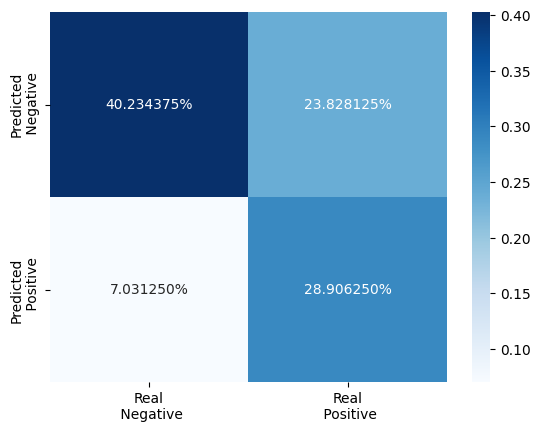

In [18]:
fig, ax = plt.subplots()

sns.heatmap(
    confusion_matrix / NUM_IMAGES,
    annot=True,
    fmt="%",
    cmap="Blues",
    ax=ax,
)

ax.set_xticklabels(["Real\n Negative", "Real\n Positive"])
ax.set_yticklabels(["Predicted\n Negative", "Predicted\n Positive"])

del fig, ax

 The confusion matrix shows:
 - True Negatives (correctly identified images without ellipses)
 - False Positives (incorrectly identified images without ellipses as having ellipses)
 - False Negatives (incorrectly identified images with ellipses as not having ellipses)
 - True Positives (correctly identified images with ellipses)

 This gives us insight into the classification performance of our quantum neural network.